## 1. Requirements

In [2]:
import numpy as np
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import cv2
import torchvision.transforms as transforms
from PIL import Image

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Set Args

In [39]:
eps = 0.007
use_cuda = True

## 3. Prepare Data

label giant_panda


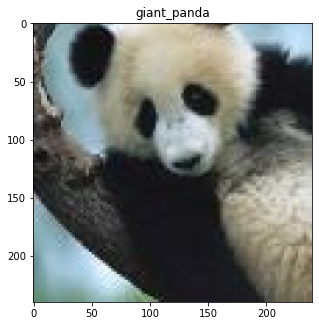

(240, 240, 3)

In [12]:
# https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
class_idx = json.load(open("./data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
labels = torch.tensor([388])
print("label", idx2label[388])
#print("idx2label", idx2label)
# load image
img_path = "./data/giant_panda/1.jpg"
img = np.array(Image.open(img_path))
def imshow(img, title):
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(img)
    plt.title(title)
    plt.show()
imshow(img, idx2label[labels])
img.shape

## 4. Prepare Model and Loss

In [7]:
device = torch.device("cuda:7" if use_cuda else "cpu")
#model = models.inception_v3(pretrained=True).to(device)

## simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
model = models.resnet50(pretrained=True).to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [26]:

img_t = torch.from_numpy(img).permute(2,0,1).unsqueeze(0).to(device).float() / 255.0
pred_class= int(model(norm(img_t)).argmax())
pred_label = idx2label[pred_class]
print("pred_class", pred_class, "pred_label", pred_label)


pred_class 388 pred_label giant_panda


In [28]:
loss = nn.CrossEntropyLoss()

## 5. Adversarial Attack

In [56]:
def fgsm_attack(model, loss, images, labels, eps, iterations=1) :
    
    images = images.to(device)
    labels = labels.to(device)
    delta = torch.zeros(images.shape).to(device)
   
    for i in range(iterations):    
        delta.requires_grad = True
        outputs = model(norm(images+delta))
        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()
        delta = delta + (eps/iterations)*delta.grad.sign()
        delta = delta.detach()
        delta = torch.clamp(delta, -eps, eps)
        
    print("delta", delta.max())
        
    attack_images = torch.clamp(images+delta, 0, 1)
    
    return attack_images

## 5. Results

In [57]:
attack_images = fgsm_attack(model, loss, img_t, labels, eps=0.07, iterations=10)
pred_class= int(model(norm(attack_images)).argmax())
pred_label = idx2label[pred_class]
print("pred_class", pred_class, "pred_label", pred_label)


delta tensor(0.0700, device='cuda:7')
pred_class 384 pred_label indri


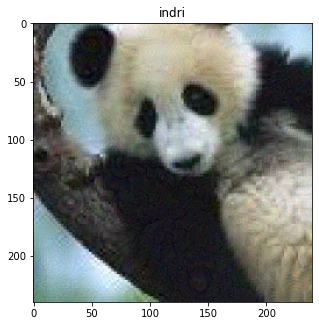

In [58]:
# visualize adversarial examples
imshow(attack_images.squeeze().permute(1,2,0).cpu().numpy(), idx2label[pred_class])

## 6. Target Attack

In [70]:
def fgsm_attack_target(model, loss, images, target_labels, eps, iterations=1) :
    
    images = images.to(device)
    target_labels = target_labels.to(device)
    delta = torch.zeros(images.shape).to(device)
   
    for i in range(iterations):    
        delta.requires_grad = True
        outputs = model(norm(images+delta))
        model.zero_grad()
        cost = loss(outputs, target_labels).to(device)
        cost.backward()
        #delta = delta + (eps/iterations)*delta.grad.sign()
        delta = delta - (eps/iterations)*delta.grad.sign() # gradient descent
        delta = delta.detach()
        delta = torch.clamp(delta, -eps, eps)
        
    print("delta", delta.max())
        
    attack_images = torch.clamp(images+delta, 0, 1)
    
    return attack_images

In [71]:
target_label = torch.tensor([0])
target_class = idx2label[target_label]
print("target_label", target_label, "target_class", target_class)

target_label tensor([0]) target_class tench


In [75]:
attack_images = fgsm_attack_target(model, loss, img_t, target_label, eps=0.7, iterations=8)
pred_class= int(model(norm(attack_images)).argmax())
pred_label = idx2label[pred_class]
print("pred_class", pred_class, "pred_label", pred_label)

delta tensor(0.7000, device='cuda:7')
pred_class 0 pred_label tench
